
# Robo-Advisory: Mean Variance Portofolio Optimization with different objectives

The objective of this notebook is to create a Robo Advisor based on Markowitz's efficient frontier, the client's objective and risk profile. Sources and recommended lectures:

Cf. Markowitz Harry (1952): "Portfolio Selection." Journal of Finance, vol.7, 77-91.
Yves Hilpisch (2015): "Python for Finance". O'Really.


In [71]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import datetime as dt
import matplotlib.pyplot as plt
import scipy.optimize as sco
plt.style.use('seaborn')
%matplotlib inline

In [347]:
# We set a period of days in a look back time in order to create historic time series
lookbacktime = 520
d = dt.date.today() - dt.timedelta(days=lookbacktime)

In [348]:
# We define the univeerse of assets that the Robo Advisor may be able con recommmend
tickers = ['SPY', 'QQQ', 'EEM', 'GLD', 'BND', 'VNQ']
number_of_assets = len(tickers)

In [349]:
# We download de data
data = pdr.get_data_yahoo(tickers, start=d, end=dt.date.today())['Adj Close'] 

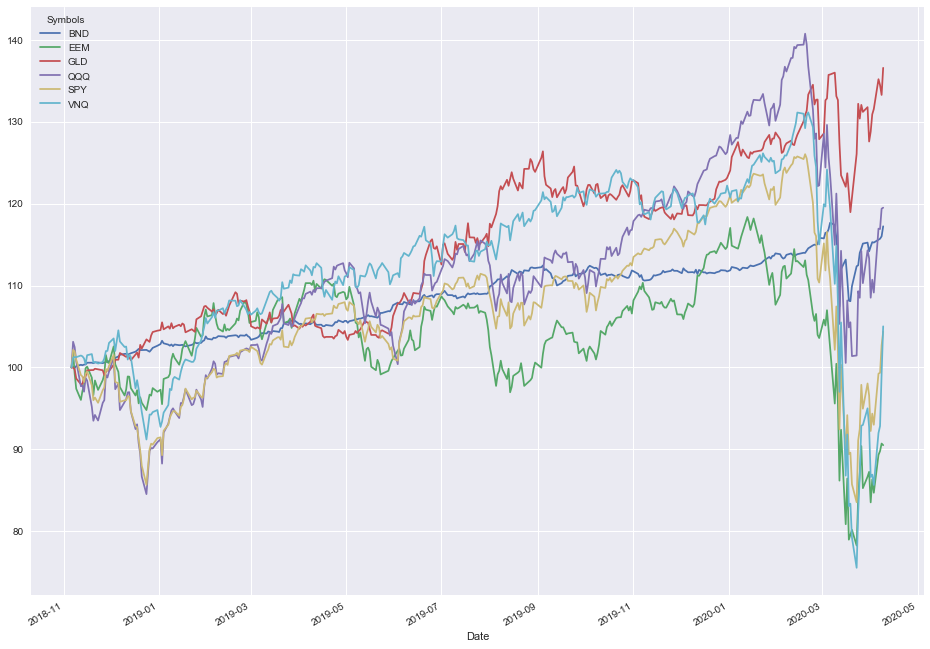

In [350]:
(data/data.iloc[0] * 100).plot(figsize=(16,12))

In [351]:
# We create a Data Frame with the returns
returns = pd.DataFrame()
for ticker in tickers:
    column = ticker + '_return'
    returns[column] = data[ticker].pct_change()


In [352]:
returns.dropna(inplace=True)
returns.head(10)

,SPY_return,QQQ_return,EEM_return,GLD_return,BND_return,VNQ_return
Date,,,,,,
2018-11-07,0.021409,0.031367,0.018845,-0.000086,0.000903,0.011935
2018-11-08,-0.001815,-0.006379,-0.025943,-0.002155,-0.001675,0.000745
2018-11-09,-0.009768,-0.016852,-0.018496,-0.011228,0.002452,-0.000124
2018-11-12,-0.018685,-0.030259,-0.014070,-0.007163,0.001545,0.001985
2018-11-13,-0.001871,0.000842,0.011468,0.000352,-0.000514,-0.000991
2018-11-14,-0.006837,-0.007629,0.006047,0.008267,0.000772,-0.002479
2018-11-15,0.010437,0.017494,0.022289,0.001134,0.000128,-0.006834
2018-11-16,0.002601,-0.003510,0.001960,0.007406,0.002184,0.010759
2018-11-19,-0.016914,-0.032478,-0.013448,0.000432,0.000000,0.001362


In [375]:
# The annualized return of eeach asset is:
returns_annualized = returns.mean() * 252
returns_annualized

SPY_return    0.068454
QQQ_return    0.170224
EEM_return   -0.030233
GLD_return    0.231121
BND_return    0.115481
VNQ_return    0.087244
dtype: float64

In [354]:
# The annualize covariance matrix is:
cov = returns.cov() * 252
cov

,SPY_return,QQQ_return,EEM_return,GLD_return,BND_return,VNQ_return
SPY_return,0.075998,0.079051,0.067460,0.001964,0.003614,0.074930
QQQ_return,0.079051,0.088418,0.071387,0.001282,0.002339,0.072228
EEM_return,0.067460,0.071387,0.078858,0.003736,0.004110,0.065539
GLD_return,0.001964,0.001282,0.003736,0.022061,0.004240,0.008444
BND_return,0.003614,0.002339,0.004110,0.004240,0.006445,0.006796
VNQ_return,0.074930,0.072228,0.065539,0.008444,0.006796,0.102359


Assumptions: there are only long positions and there is no leverage, therefore a portfolio is composed by a non-negative set of weeights, =< 1 each, and all together must sum 1.

In [355]:
weights = np.random.random(number_of_assets)
weights /= np.sum(weights)
weights

array([0.13080039, 0.1731529 , 0.27172037, 0.1055536 , 0.22149562,
       0.09727712])

In [356]:
sum(weights)

1.0

The expected return of the portfolio can be estimated by the weighted historical return of every asset, assuming that historical behavior is the best predictor of future behaivor -we are not digging any deeper just now about that-

In [357]:
expected_portfolio_return = np.sum(returns_annualized * weights)
expected_portfolio_return

0.08867474181280258

The expected covariance of the portfolio is wT.COV.w

In [358]:
expected_portfolio_variance = np.dot(weights.T, np.dot(cov, weights))
expected_portfolio_variance

0.036065569840414

The expected standard deviation of the portfolio is the square root of the former. Also we'll define it as the portfolio volatility

In [359]:
expected_portfolio_std = np.sqrt(expected_portfolio_variance)
expected_portfolio_std

0.18990937270291322

There is absolutely no need of creating a sample of the universe of possible portfolios but we can do it just for the sake of understangin MPT. We use a Monte Carlo simulation to plot a number of posible portfolios based on different allocations (weights) on the same assets. You may find several articles on this. 

In [360]:
expected_portfolios_returns = []
expected_portfolios_volatilities = []
expected_portfolios_sharpe_ratios = []
risk_free_interest_rate = 0

for i in range(100000):
    weights = np.random.uniform(low=0.0, high=1.0, size=number_of_assets)
    weights /= np.sum(weights)
    expected_portfolio_returns = np.sum(returns_annualized * weights)
    expected_portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    expected_portfolio_sharpe_ratio = (expected_portfolio_returns - risk_free_interest_rate)/ expected_portfolio_volatility
    expected_portfolios_returns.append(expected_portfolio_returns)
    expected_portfolios_volatilities.append(expected_portfolio_volatility)
    expected_portfolios_sharpe_ratios.append(expected_portfolio_sharpe_ratio)

In [361]:
expected_portfolios_returns = np.array(expected_portfolios_returns)
expected_portfolios_volatilities = np.array(expected_portfolios_volatilities)
expected_portfolios_sharpe_ratios = np.array(expected_portfolios_sharpe_ratios)

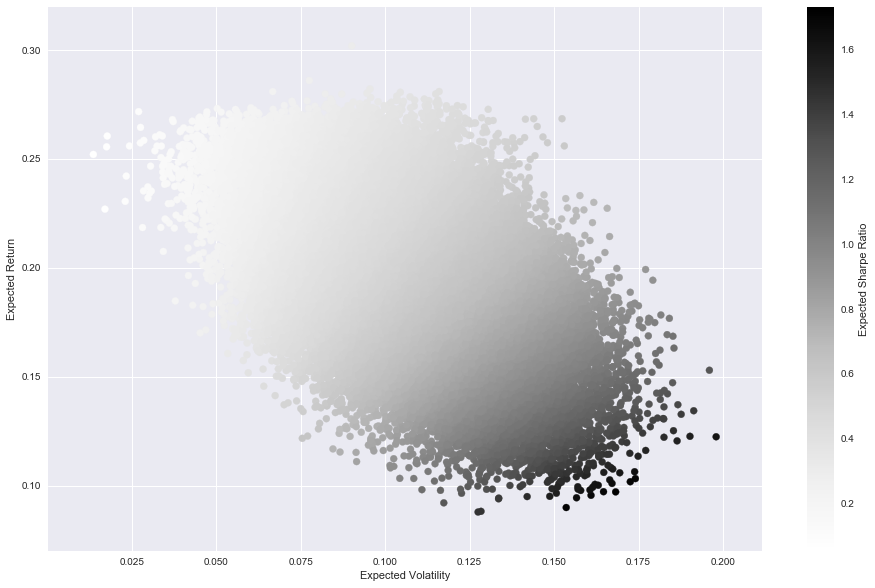

In [362]:
plt.figure(figsize = (16,10))
plt.scatter(expected_portfolios_returns, expected_portfolios_volatilities, c=expected_portfolios_sharpe_ratios, marker='o')
plt.grid(True)
plt.ylabel('Expected Return')
plt.xlabel('Expected Volatility')
plt.colorbar(label='Expected Sharpe Ratio')

The hole objective of this Robo Advisor will be to recommend one of the best possible portfolios in the graph, based on both risk and return. We will need to know the investor's profile and preference in order to know if wee should maximize returns whit the minimum risk possible for greedy investors or if the robo-advisor should minimize risk and provide the best return for that amount of risk. For the optimization we will follow Yves Hilpsisch methodology and further the analysis by adding profile-based contraints. We shall need a constraint in the form of a required return or as a risk parameter such as volatility mapped with the different investors profiles. In our experience, normally the risk parameter is much more important.

In [363]:
#We can use a linspace function to model the different scales of volatilies according to the possible universe
min_volatility = expected_portfolios_volatilities.min()
max_volatility = expected_portfolios_volatilities.max()
volatility_range= np.linspace(min_volatility, max_volatility, num=7)
profiles = ['conservative', 'moderate_conservative', 'moderate', 'moderate_growth', 'growth', 'aggresive_growth', 'aggresive']

In [364]:
investors_profiles = dict(zip(profiles, volatility_range))
print(investors_profiles)

{'conservative': 0.08789585105320874, 'moderate_conservative': 0.12355829796002268, 'moderate': 0.15922074486683663, 'moderate_growth': 0.19488319177365054, 'growth': 0.2305456386804645, 'aggresive_growth': 0.26620808558727843, 'aggresive': 0.30187053249409235}


We create objectives functions in order to optimize.

In [376]:
def portfolio_statistics(weights):
    
    '''
    Returns the statistics of a given portfolio as a function of the allocation (weights).
    '''
    weights = np.array(weights)
    expected_portfolio_return = np.sum(returns_annualized * weights)
    expected_portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    expected_portfolio_sharpe_ratio = (expected_portfolio_returns - risk_free_interest_rate)/ expected_portfolio_volatility
    return np.array([expected_portfolio_return, expected_portfolio_volatility, expected_portfolio_sharpe_ratio])


In [409]:
def maximize_return(weights):
    return -portfolio_statistics(weights)[0]

def minimize_volatility(weights):
    return portfolio_statistics(weights)[1]

def maximize_sharpe_ratio(weights):
    return -portfolio_statistics(weights)[2]

We set up generals contraints and bounds for the weights. In this case there is no short trades and all the liquidity must be invested.

In [410]:
opt_general_constraints = {'type':'eq', 'fun': lambda x: np.sum(x)-1}

In [487]:
opt_bounds = tuple((0,1) for x in range(number_of_assets))

We set specific Constraints for every of the three specific problems. You will notice that both max returns and max sharpe ratio are attached to a volatility constraint.

In [494]:
def max_return_specific_constraints(profiles):
    constraints = ({'type':'eq', 'fun': lambda x: np.sum(x)-1},
                       {'type':'ineq', 'fun': lambda x:  investors_profiles.get(profiles) - np.sqrt(np.dot(x.T, np.dot(cov, x)))}
                      )
    return constraints

def min_volatility_specific_constraints(target_return):
    constraints = ({'type':'eq', 'fun': lambda x: np.sum(x)-1},
                       {'type':'ineq', 'fun': lambda x:  np.sum(returns_annualized * x) - target_return}
                      )
    return constraints

def sharpe_ratio_specific_constraints(profiles):
    constraints = ({'type':'eq', 'fun': lambda x: np.sum(x)-1},
                       {'type':'ineq', 'fun': lambda x:  investors_profiles.get(profiles) - np.sqrt(np.dot(x.T, np.dot(cov, x)))}
                      )
    return constraints

We define a function for each problem or objective, based on the client's profile.

In [498]:
def optimize_returns(profiles):
    
    max_return = sco.minimize(maximize_return, number_of_assets * [1. / number_of_assets], method='SLSQP', 
                                bounds= opt_bounds, constraints=(max_return_specific_constraints(profiles)))
    w = max_return['x'].round(8)
    return w


def optimize_volatility(target_return):
    
    if target_return < expected_portfolios_returns.max():
        max_return = sco.minimize(minimize_volatility, number_of_assets * [1. / number_of_assets], method='SLSQP', 
                                    bounds= opt_bounds, constraints=(min_volatility_specific_constraints(profiles)))
        w = target_return['x'].round(8)
        return w
    else:
        return print('{} is not a feasible return in the current market.'.format(target_return))

    
def optimize_sharpe_ratio(profiles):
    
    op_sharpe = sco.minimize(maximize_sharpe_ratio, number_of_assets * [1. / number_of_assets], method='SLSQP', 
                                bounds= opt_bounds, constraints=(sharpe_ratio_specific_constraints(profiles)))
    w = op_sharpe['x'].round(8)
    return w

In [499]:
def robo_advisor(objective='sharpe_ratio', profiles=None, target_return=None, wealth=None ):
    
    if objective == 'max_returns':
        allocation = optimize_returns(profiles) * wealth
        recommendation = dict(zip(tickers, allocation))
        return recommendation
    
    if objective == 'min_volatility':
        try: 
            allocation = optimize_volatility(target_return) * wealth
            recommendation = dict(zip(tickers, allocation))
            return recommendation
        except:
            return print('{} is not a feasible return in the current market.'.format(target_return))
    
    if objective == 'sharpe_ratio':
        allocation = optimize_sharpe_ratio(profiles) * wealth
        recommendation = dict(zip(tickers, allocation))
        return recommendation

In [500]:
robo_advisor(objective='sharpe_ratio', profiles='moderate', wealth=100000)

{'SPY': 0.0,
 'QQQ': 4417.884,
 'EEM': 0.0,
 'GLD': 10755.173,
 'BND': 84826.944,
 'VNQ': 0.0}